---
### Analytic solution: Solving for lambda and Y

An optimisation using already-built python optimisation library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from joblib import Parallel, delayed
import pandas as pd
import time

# Constants
a1 = 23.8
a2 = 1.42
k1 = 0.1
k2 = 0.003
N = 100
b_min = 1
b_max = 10000
b_vals = np.logspace(np.log10(b_min), np.log10(b_max), N)
#b_vals = np.linspace(b_min, b_max, N+1)

print(r'$np.sqrt(k1/a1) = $' + str(np.sqrt(k1/a1)))
print(r'$np.sqrt(k2/a2) = $' + str(np.sqrt(k2/a2)))

# Approximate theory parameters
A = np.sqrt(k1/a1) + np.sqrt(k2/a2)
Z = ((1+k1+k1*k2)*a1 + (1+k1)**2*a2)/((1+k1)**2*k2)
print(Z*0.03**2 + 0.03)

$np.sqrt(k1/a1) = $0.06482037235521644
$np.sqrt(k2/a2) = $0.045963855977692175
6.948679338842974


### Softmax transformation

In [2]:
# Softmax transformation from u1, u2 -> theta1, theta2, theta3 (LogSumExp)
from scipy.special import logsumexp
def softmax_partition(u):
    u1, u2 = u
    logZ = logsumexp([u1, 0.0, u2])
    theta1 = np.exp(u1 - logZ)
    theta2 = np.exp(-logZ)
    theta3 = np.exp(u2 - logZ)
    return theta1, theta2, theta3

# Objective function for fixed b_val using softmax
def objective_softmax(u, b_val):
    try:
        theta1, theta2, theta3 = softmax_partition(u)
        if theta1 <= 0 or theta3 <= 0:
            return np.inf
        term_Y1 = (a1 * theta2) / (b_val * theta1) + k1 - 1
        Y1 = 0.5 * (np.sqrt(term_Y1**2 + 4 * k1) - term_Y1)
        term_Y2 = (a2 * theta3) / (b_val * theta1) + k2 - (1 - Y1)
        Y2 = 0.5 * (np.sqrt(term_Y2**2 + 4 * (1 - Y1) * k2) - term_Y2)
        if np.isnan(Y1) or np.isnan(Y2) or Y1 < 0 or Y2 < 0:
            return np.inf
        Y3 = (a2 * theta3 / b_val) * (Y2 / (k2 + Y2))
        return -b_val * Y3  # Negative lambda (maximize lambda)
    except:
        return np.inf

def optimize_for_b_softmax(b_val):
    result = minimize(lambda u: objective_softmax(u, b_val), [0.0, 0.0], method='BFGS')
    if result.success:
        theta1, theta2, theta3 = softmax_partition(result.x)
        term_Y1 = (a1 * theta2) / (b_val * theta1) + k1 - 1
        Y1 = 0.5 * (np.sqrt(term_Y1**2 + 4 * k1) - term_Y1)
        term_Y2 = (a2 * theta3) / (b_val * theta1) + k2 - (1 - Y1)
        Y2 = 0.5 * (np.sqrt(term_Y2**2 + 4 * (1 - Y1) * k2) - term_Y2)
        Y3 = (a2 * theta3 / b_val) * (Y2 / (k2 + Y2))
        Y4 = (a2 * theta2 * theta3 / (b_val * theta1)) * (Y2 / (k2 + Y2))
        Y5 = (a2 * theta3**2 / (b_val * theta1)) * (Y2 / (k2 + Y2))
        lambda_val = b_val * Y3
        r_denom = ((k1 + Y1) / (a1 * Y4)) + ((k2 + Y2) / (a2 * Y5))
        r_avg = 1 / r_denom if r_denom != 0 else np.nan
        return [b_val, [theta1, theta2, theta3], [Y1, Y2, Y3, Y4, Y5], lambda_val, r_avg]
    return None

# Parallel execution
start = time.time()
results = Parallel(n_jobs=-1)(delayed(optimize_for_b_softmax)(b) for b in b_vals)
results = [r for r in results if r is not None]
print(f"Optimization completed in {time.time() - start:.2f} seconds.")

# Organize into arrays
b_arr = np.array([r[0] for r in results])
theta_arr = np.array([r[1] for r in results])
Y_arr = np.array([r[2] for r in results])
lambda_arr = np.array([r[3] for r in results])
r_avg_arr = np.array([r[4] for r in results])

theta1_arr, theta2_arr, theta3_arr = theta_arr.T
Y1_arr, Y2_arr, Y3_arr, Y4_arr, Y5_arr = Y_arr.T

Optimization completed in 2.45 seconds.


### Line fitting

In [10]:
from scipy.stats import linregress
# Perform linear regression
def linear_fit(x, y):
  slope, intercept, r_value, p_value, std_err = linregress(x, y)
  x_fit = np.linspace(min(x), max(x), 201)
  y_fit = slope * x_fit + intercept
  r_squared = r_value**2
  return [x_fit, y_fit, r_squared, slope, intercept]

# lambda vs. b (linear)
b_lambda_fit = linear_fit(b_arr, lambda_arr)
b_Y5_fit = linear_fit(b_arr, Y5_arr)
Y3_lambda_fit = linear_fit(Y3_arr, lambda_arr)
Y4_lambda_fit = linear_fit(Y4_arr, lambda_arr)
Y5_lambda_fit = linear_fit(Y5_arr, lambda_arr)

### Plot the result

C:\Users\huang\AppData\Local\Temp\ipykernel_7156\4150817359.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend() # show the label


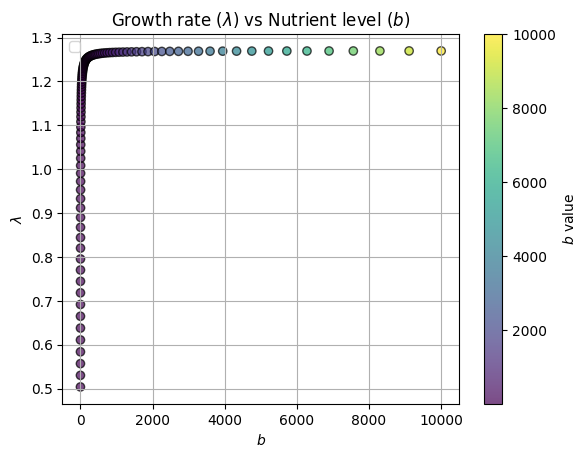

C:\Users\huang\AppData\Local\Temp\ipykernel_7156\4150817359.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


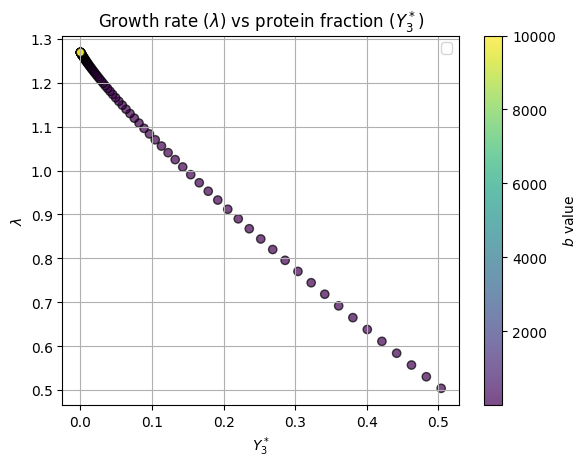

C:\Users\huang\AppData\Local\Temp\ipykernel_7156\4150817359.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


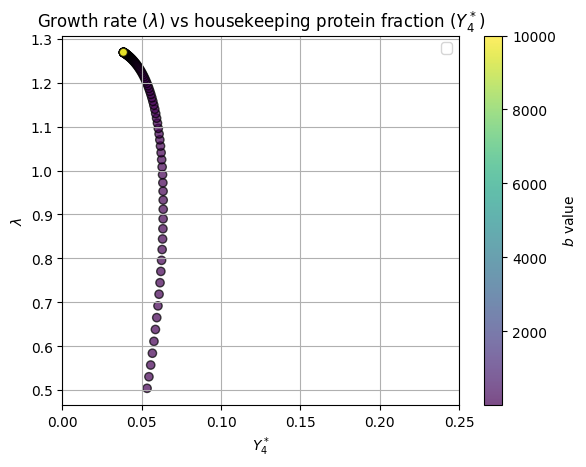

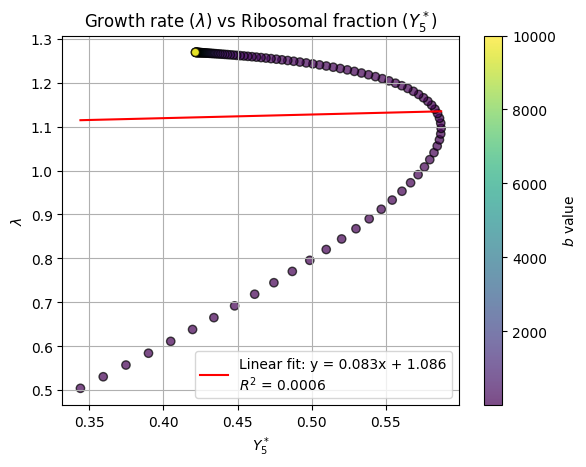

C:\Users\huang\AppData\Local\Temp\ipykernel_7156\4150817359.py:60: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


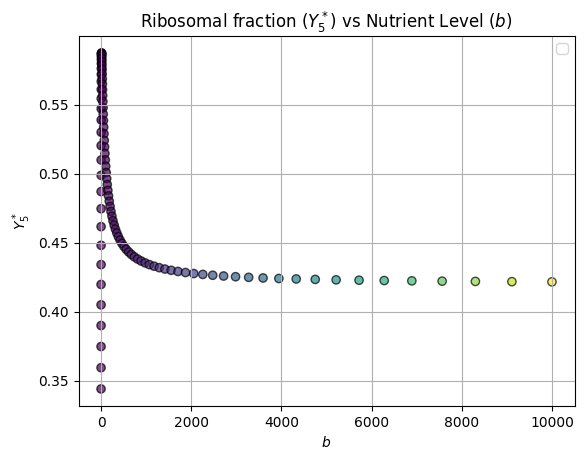

C:\Users\huang\AppData\Local\Temp\ipykernel_7156\4150817359.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


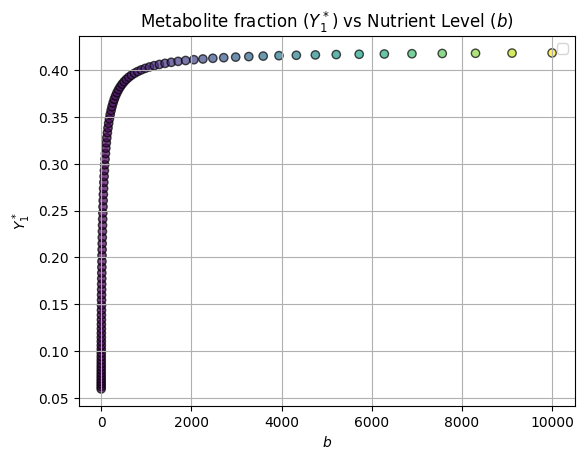

In [11]:
# Growth rate to nutrient level (b)
lambda_approx_arr = b_arr - 2*(np.sqrt(k1/a1) + np.sqrt(k2/a2))*b_arr**(3/2)

plt.figure()
scatter = plt.scatter(b_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
# plt.plot(b_arr, lambda_approx_arr, lw=2, label='approximate theory', color='blue') # theory prediction
#plt.plot(b_lambda_fit[0], b_lambda_fit[1], '-', label=f'Linear fit: y = {b_lambda_fit[3]:.3f}x + {b_lambda_fit[4]:.3f}\n$R^2$ = {b_lambda_fit[2]:.4f}', color='red') # line of best fit
plt.xlabel(r'$b$')
plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs Nutrient level ($b$)')
plt.legend() # show the label
plt.grid(True)
plt.show()

# Growth rate to protein fraction (Y3)
plt.figure()
scatter = plt.scatter(Y3_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
# plt.plot(Y3_lambda_fit[0], Y3_lambda_fit[1], '-', label=f'Linear fit: y = {Y3_lambda_fit[3]:.3f}x + {Y3_lambda_fit[4]:.3f}\n$R^2$ = {Y3_lambda_fit[2]:.4f}', color='red') # line of best fit
plt.xlabel(r'$Y_3^*$')
plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs protein fraction ($Y_3^*$)')
plt.grid(True)
plt.legend()
plt.show()

# Growth rate to protein fraction (Y4) -> this should be constant
plt.figure()
scatter = plt.scatter(Y4_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
#plt.plot(Y4_lambda_fit[0], Y4_lambda_fit[1], '-', label=f'Linear fit: y = {Y4_lambda_fit[3]:.3f}x + {Y4_lambda_fit[4]:.3f}\n$R^2$ = {Y4_lambda_fit[2]:.4f}', color='red') # line of best fit
plt.xlabel(r'$Y_4^*$')
plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs housekeeping protein fraction ($Y_4^*$)')
plt.grid(True)
plt.xlim(0, 0.25)
plt.legend()
plt.show()

# Growth rate to ribosomal fraction (Y5)
plt.figure()
scatter = plt.scatter(Y5_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.plot(Y5_lambda_fit[0], Y5_lambda_fit[1], '-', label=f'Linear fit: y = {Y5_lambda_fit[3]:.3f}x + {Y5_lambda_fit[4]:.3f}\n$R^2$ = {Y5_lambda_fit[2]:.4f}', color='red') # line of best fit
plt.xlabel(r'$Y_5^*$')
plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs Ribosomal fraction ($Y_5^*$)')
plt.grid(True)
plt.legend()
plt.show()

# Ribosomal fraction (Y5) to nutrient level (b)
plt.figure()
scatter = plt.scatter(b_arr, Y5_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.xlabel(r'$b$')
plt.ylabel(r'$Y_5^*$')
plt.title(r'Ribosomal fraction ($Y_5^*$) vs Nutrient Level $(b)$')
plt.grid(True)
plt.legend()
plt.show()

# Metabolite fraction (Y1) to nutrient level (b)
plt.figure()
scatter = plt.scatter(b_arr, Y1_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.xlabel(r'$b$')
plt.ylabel(r'$Y_1^*$')
plt.title(r'Metabolite fraction ($Y_1^*$) vs Nutrient Level $(b)$')
plt.grid(True)
plt.legend()
plt.show()

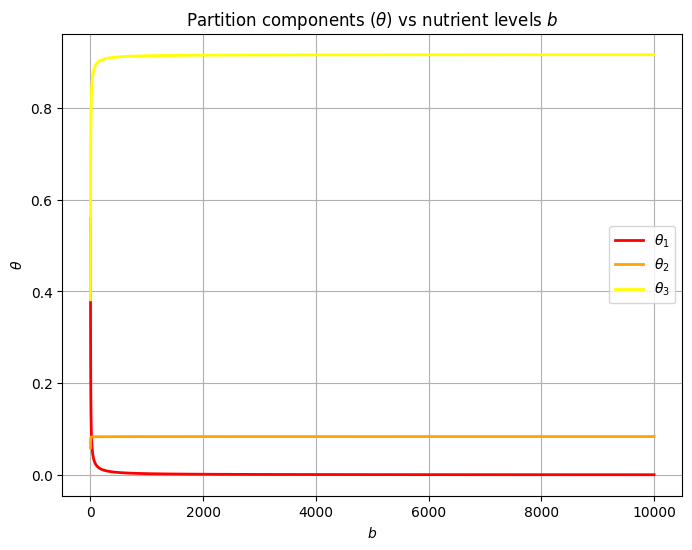

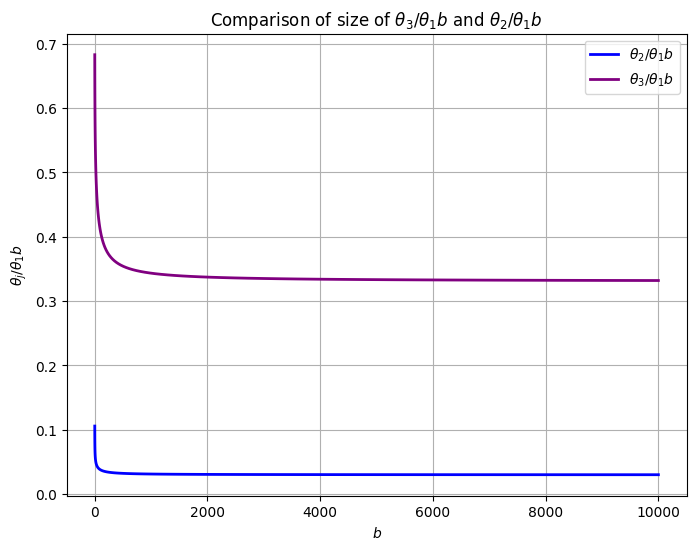

Q = 
[0.10588486 0.1028328  0.09991146 0.09711484 0.09443447 0.09186836
 0.08940682 0.08704797 0.08478658 0.08261595 0.08053385 0.07853467
 0.07661505 0.07477082 0.07299853 0.07129425 0.06965498 0.06807754
 0.06655897 0.06509618 0.06368687 0.06232771 0.0610169  0.05975259
 0.05853098 0.0573519  0.05621267 0.05511157 0.05404665 0.05301749
 0.05202143 0.05105823 0.05012463 0.04922192 0.04834762 0.04750184
 0.04668309 0.04589162 0.04512428 0.04438261 0.04366595 0.04297305
 0.04230417 0.0416586  0.04103667 0.04043544 0.03985886 0.03930338
 0.03877007 0.03825831 0.0377692  0.0372988  0.03685092 0.0364234
 0.03601473 0.03562832 0.03526008 0.03491149 0.03458102 0.03426929
 0.0339752  0.03369794 0.03343735 0.03319276 0.03296379 0.03274857
 0.03254867 0.0323618  0.03218764 0.03202556 0.03187508 0.03173548
 0.0316061  0.03148638 0.03137562 0.03127327 0.03117915 0.03109223
 0.03101246 0.03093841 0.03087069 0.03080888 0.03075131 0.03069913
 0.03065081 0.03060673 0.03056626 0.03052917 0.03049376 0.

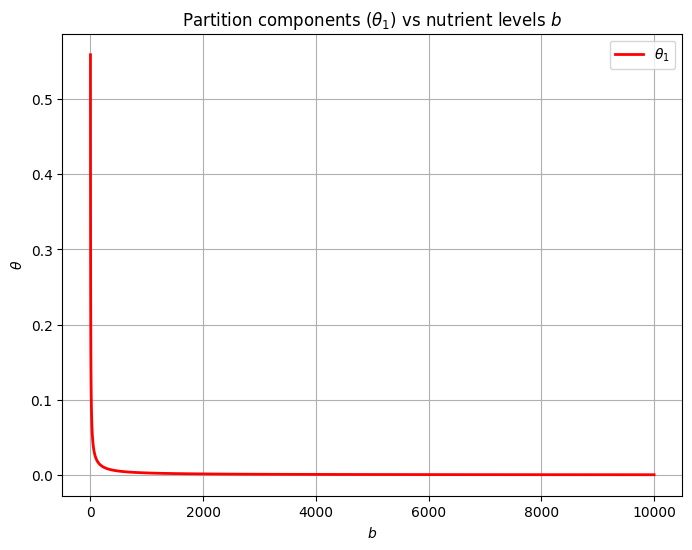

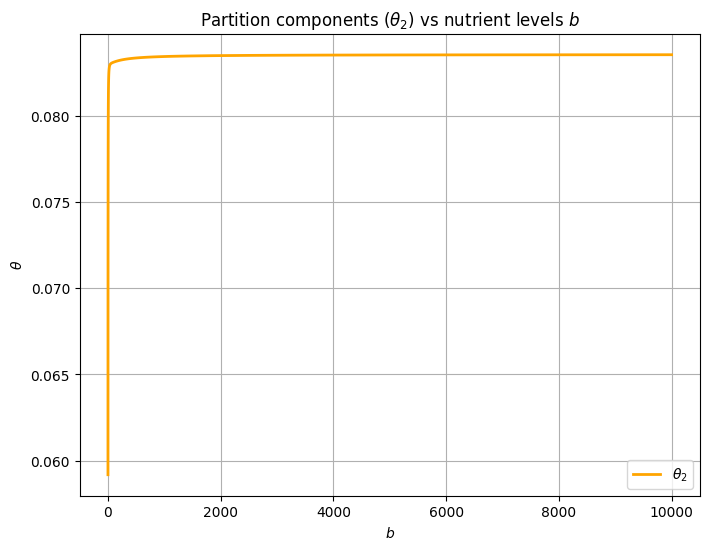

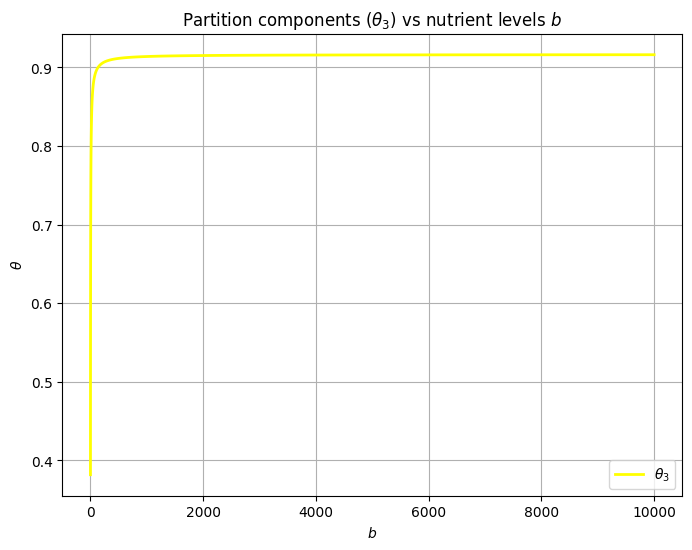

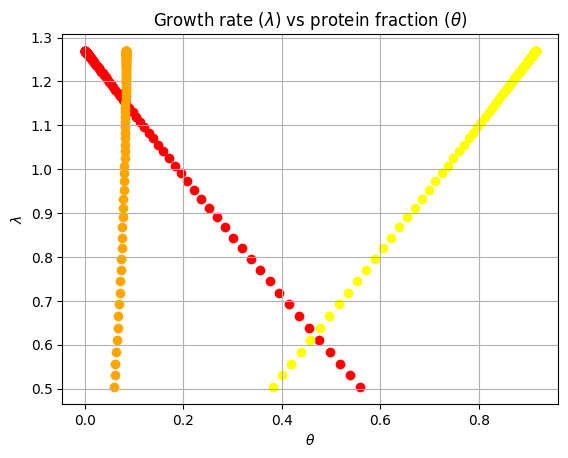

In [13]:
plt.figure(figsize=(8,6)) # set size of the graph (call before plt.plot)
plt.plot(b_arr, theta1_arr, lw=2, label=r'$\theta_1$', color='red')
plt.plot(b_arr, theta2_arr, lw=2, label=r'$\theta_2$', color='orange')
plt.plot(b_arr, theta3_arr, lw=2, label=r'$\theta_3$', color='yellow')
plt.xlabel(r'$b$')
plt.ylabel(r'$\theta$')
plt.title(r'Partition components ($\theta$) vs nutrient levels $b$')
plt.grid(True)
plt.legend()
plt.show()

Q_arr = theta2_arr/(theta1_arr*b_arr)
R_arr = theta3_arr/(theta1_arr*b_arr)
plt.figure(figsize=(8,6)) # set size of the graph (call before plt.plot)
plt.plot(b_arr, Q_arr, lw=2, label=r'$\theta_2/\theta_1 b$', color='blue')
plt.plot(b_arr, R_arr, lw=2, label=r'$\theta_3/\theta_1 b$', color='purple')
plt.xlabel(r'$b$')
plt.ylabel(r'$\theta_j / \theta_1 b$')
plt.title(r'Comparison of size of $\theta_3/\theta_1 b$ and $\theta_2/\theta_1 b$')
plt.grid(True)
plt.legend()
plt.show()

print('Q = ')
print(Q_arr)
print('R = ')
print(R_arr)

# Separate theta1
plt.figure(figsize=(8,6)) # set size of the graph (call before plt.plot)
plt.plot(b_arr, theta1_arr, lw=2, label=r'$\theta_1$', color='red')
plt.xlabel(r'$b$')
plt.ylabel(r'$\theta$')
plt.title(r'Partition components ($\theta_1$) vs nutrient levels $b$')
plt.grid(True)
plt.legend()
plt.show()

# Separate theta2
plt.figure(figsize=(8,6)) # set size of the graph (call before plt.plot)
plt.plot(b_arr, theta2_arr, lw=2, label=r'$\theta_2$', color='orange')
plt.xlabel(r'$b$')
plt.ylabel(r'$\theta$')
plt.title(r'Partition components ($\theta_2$) vs nutrient levels $b$')
plt.grid(True)
plt.legend()
plt.show()

# Separate theta3
plt.figure(figsize=(8,6)) # set size of the graph (call before plt.plot)
plt.plot(b_arr, theta3_arr, lw=2, label=r'$\theta_3$', color='yellow')
plt.xlabel(r'$b$')
plt.ylabel(r'$\theta$')
plt.title(r'Partition components ($\theta_3$) vs nutrient levels $b$')
plt.grid(True)
plt.legend()
plt.show()

# Growth rate to protein partition \theta
plt.figure()
plt.scatter(theta1_arr, lambda_arr, label=r'$\theta_1$', c='red')
plt.scatter(theta2_arr, lambda_arr, label=r'$\theta_2$', c='orange')
plt.scatter(theta3_arr, lambda_arr, label=r'$\theta_3$', c='yellow')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs protein fraction ($\theta$)')
plt.grid(True)
plt.show()